# 1) Imports

In [167]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,  make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

# 2) Load and Inspect Dataset

In [168]:
df = pd.read_csv("TampinesResaleFlat_with_LatLong_with_Features.csv")

# Display dataset overview
print("Dataset Overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13363 entries, 0 to 13362
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      13363 non-null  object 
 1   town                       13363 non-null  object 
 2   flat_type                  13363 non-null  object 
 3   block                      13363 non-null  object 
 4   street_name                13363 non-null  object 
 5   storey_range               13363 non-null  object 
 6   floor_area_sqm             13363 non-null  int64  
 7   flat_model                 13363 non-null  object 
 8   lease_commence_date        13363 non-null  int64  
 9   remaining_lease            13363 non-null  object 
 10  resale_price               13363 non-null  int64  
 11  Full Address               13363 non-null  object 
 12  Latitude                   13363 non-null  float64
 13  Longitude                  1

# 3) Data Cleaning and Preprocessing

In [169]:
# Replacing NaN values with 0 for the count variables (bus_stop_count, mrt_count, mall_count, school_count)
df['bus_stop_count'] = df['bus_stop_count'].fillna(0)
df['mrt_count'] = df['mrt_count'].fillna(0)
df['mall_count'] = df['mall_count'].fillna(0)
df['school_count'] = df['school_count'].fillna(0)

# Check for missing values again to ensure the counts are handled
df.isnull().sum()

# Set a random seed for reproducibility
np.random.seed(42)

# Drop rows where 'nearest_school_distance' is missing
df.dropna(subset=['nearest_school_distance'], inplace=True)

# Fill missing values for other columns with random sampling within the range 501-1000
columns_to_fill = ['nearest_mrt_distance', 'nearest_mall_distance', 'nearest_bus_stop_distance']

for column in columns_to_fill:
    if df[column].isnull().sum() > 0:  # Only fill if there are missing values
        df[column] = df[column].apply(lambda x: np.random.randint(501, 1001) if pd.isnull(x) else x)

# Check for missing values again
df.isnull().sum()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

# Remove duplicates
df = df.drop_duplicates()

# Confirm that duplicates are removed
print(f"Number of duplicate rows after cleaning: {df.duplicated().sum()}")

#Split the month column into two separate columns: year and month
df['year'] = df['month'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))

def convert_to_months(lease_str):
    # Check if the lease string includes a months portion
    if "months" in lease_str:
        # Expected format: "<years> years <months> months"
        years = int(lease_str.split(" years ")[0])
        months = int(lease_str.split(" years ")[1].split(" months")[0])
    else:
        # Format with only years: "<years> years"
        years = int(lease_str.split(" years")[0])
        months = 0
    return years * 12 + months

df['remaining_lease_months'] = df['remaining_lease'].apply(convert_to_months)
df.drop(columns=['remaining_lease'], inplace=True)

# Initialize the encoder with drop='first' to avoid the dummy variable trap
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'flat_type' column
encoded_features = encoder.fit_transform(df[['flat_type']])

# Create a dataframe with the encoded features using the built-in method for feature names
feature_names = encoder.get_feature_names_out(['flat_type'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding flat_type) with the encoded features
df = pd.concat([df.drop('flat_type', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

# Initialize the encoder with drop='first' to drop the first category (similar to drop_first=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'street_name' column
encoded_features = encoder.fit_transform(df[['street_name']])

# Create a dataframe with the encoded features
# Get the feature names and remove the 'street_name_' prefix for cleaner column names if desired
feature_names = encoder.get_feature_names_out(['street_name'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding street_name) with the encoded features
df = pd.concat([df.drop('street_name', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

# Initialize the encoder with drop='first' to drop the first category (similar to drop_first=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'flat_model' column
encoded_features = encoder.fit_transform(df[['flat_model']])

# Create a dataframe with the encoded features
feature_names = encoder.get_feature_names_out(['flat_model'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding flat_model) with the encoded features
df = pd.concat([df.drop('flat_model', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

# Function to convert storey range to average floor level
def convert_storey_range(range_str):
    if isinstance(range_str, str):  # Ensure the value is a string before processing
        low, high = map(int, range_str.replace(' TO ', ' ').split())
        return (low + high) / 2
    return np.nan  # Return NaN if the value is not a string

# Convert storey_range to average floor level and create a new column 'storey_level'
df['storey_level'] = df['storey_range'].apply(convert_storey_range)

# Drop the 'storey_range' column as it's no longer needed
df.drop(columns=['storey_range'], inplace=True)

# Display the first few rows of the modified dataframe
df.head()

# Drop the original 'town' column
df.drop(columns=['town'], inplace=True, errors='ignore')

df.drop(columns=['block'], inplace=True, errors='ignore')

# Drop the original 'full address' column
df.drop(columns=['Full Address'], inplace=True, errors='ignore')

df.dropna(inplace=True) # failsafe method for SVR

# Check the result
print(df.head())

Missing Values:
 Series([], dtype: int64)

Number of duplicate rows: 3
Number of duplicate rows after cleaning: 0
   month      town block     street_name storey_range  floor_area_sqm  \
0    1.0  TAMPINES  299A  TAMPINES ST 22     01 TO 03            45.0   
1    1.0  TAMPINES   403  TAMPINES ST 41     01 TO 03            60.0   
2    1.0  TAMPINES   802  TAMPINES AVE 4     04 TO 06            68.0   
3    1.0  TAMPINES   410  TAMPINES ST 41     01 TO 03            69.0   
4    1.0  TAMPINES   462  TAMPINES ST 44     07 TO 09            64.0   

       flat_model  lease_commence_date  resale_price         Full Address  \
0         Model A               2012.0      250000.0  299A TAMPINES ST 22   
1        Improved               1985.0      270000.0   403 TAMPINES ST 41   
2  New Generation               1984.0      295000.0   802 TAMPINES AVE 4   
3        Improved               1985.0      300000.0   410 TAMPINES ST 41   
4      Simplified               1987.0      305000.0   462 TAM

# 4) Feature Selection and Correlation Analysis

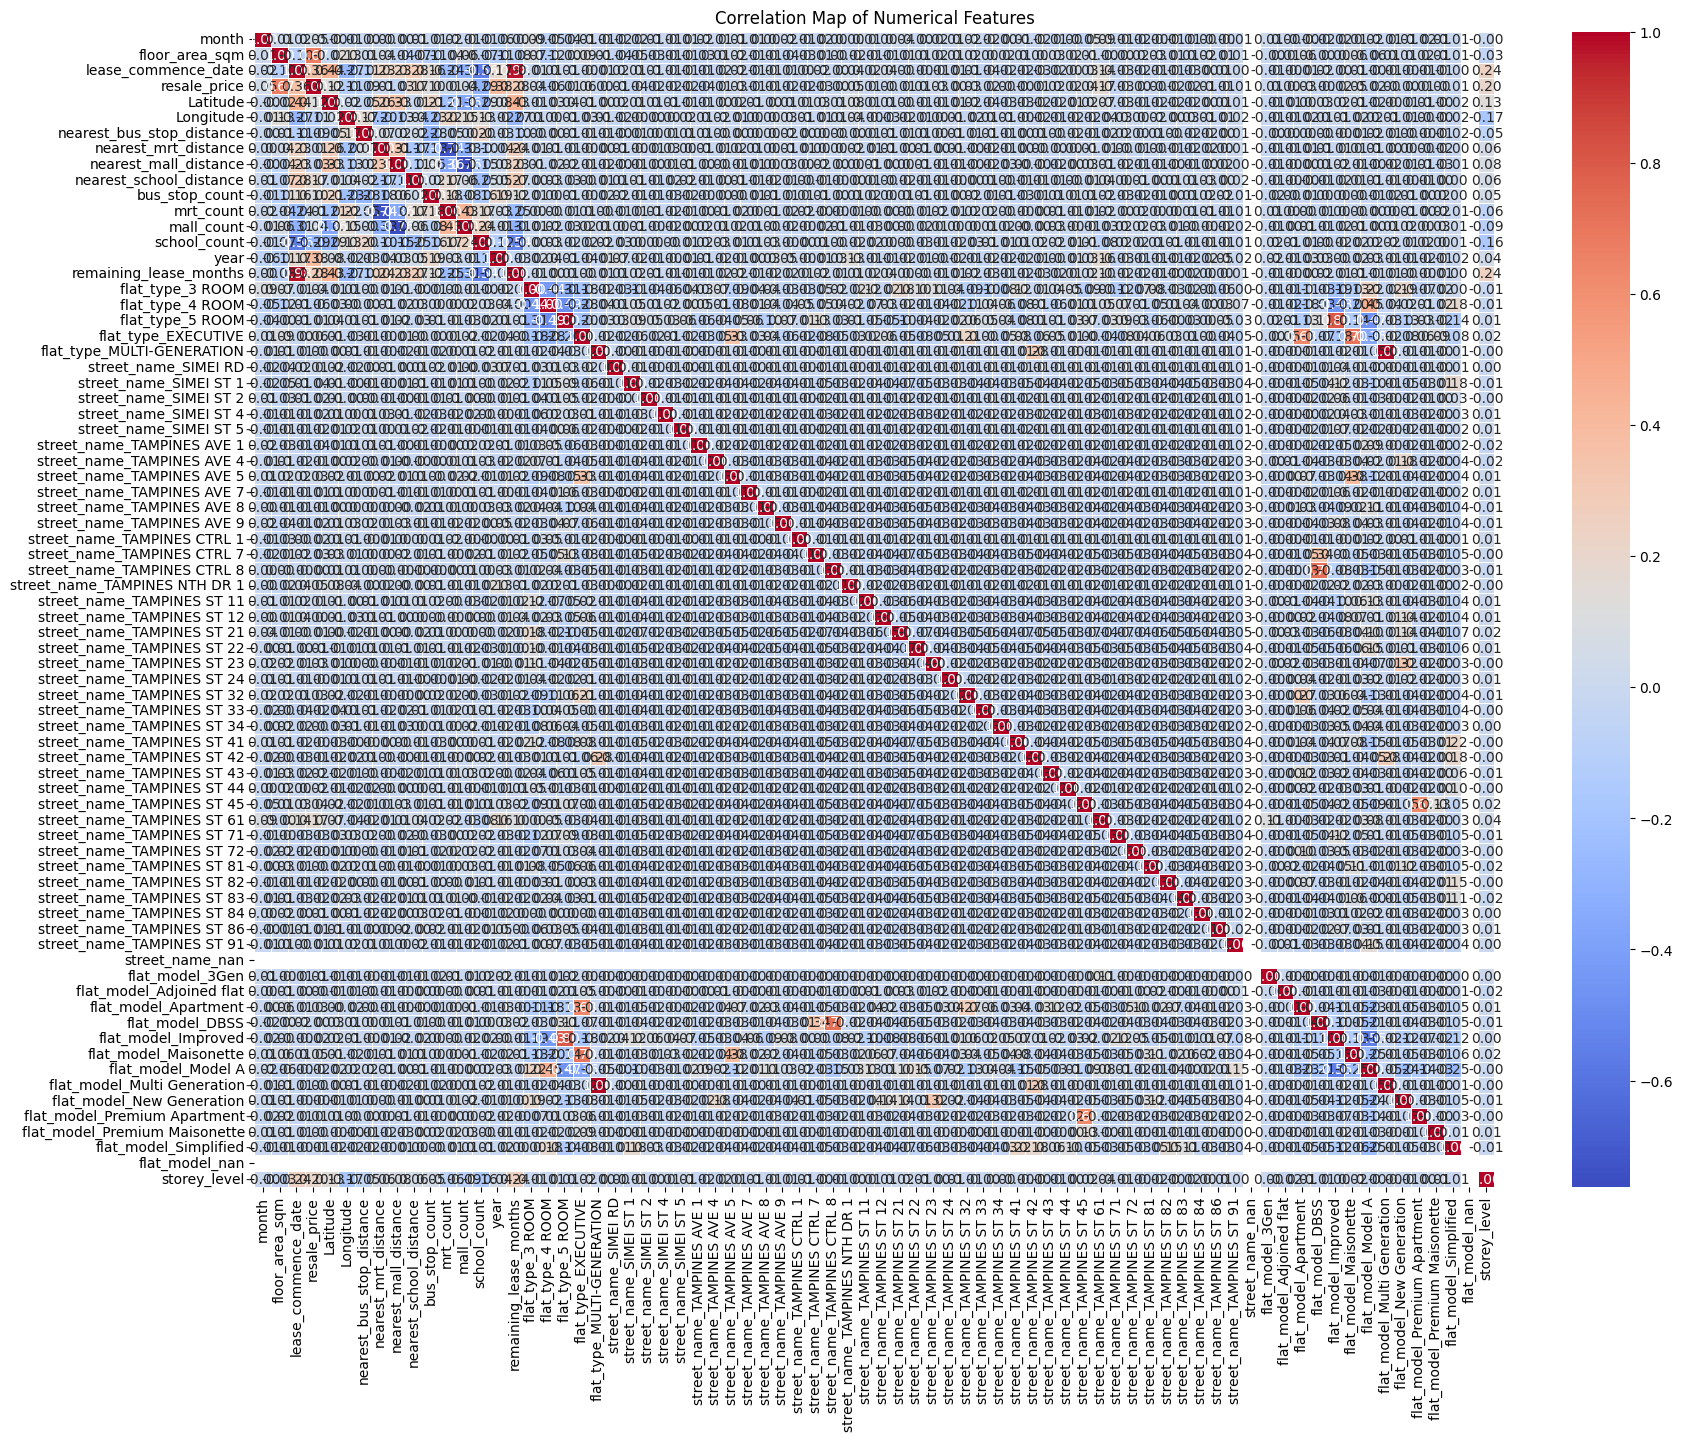

In [182]:
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the correlation map
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Map of Numerical Features')
plt.show()


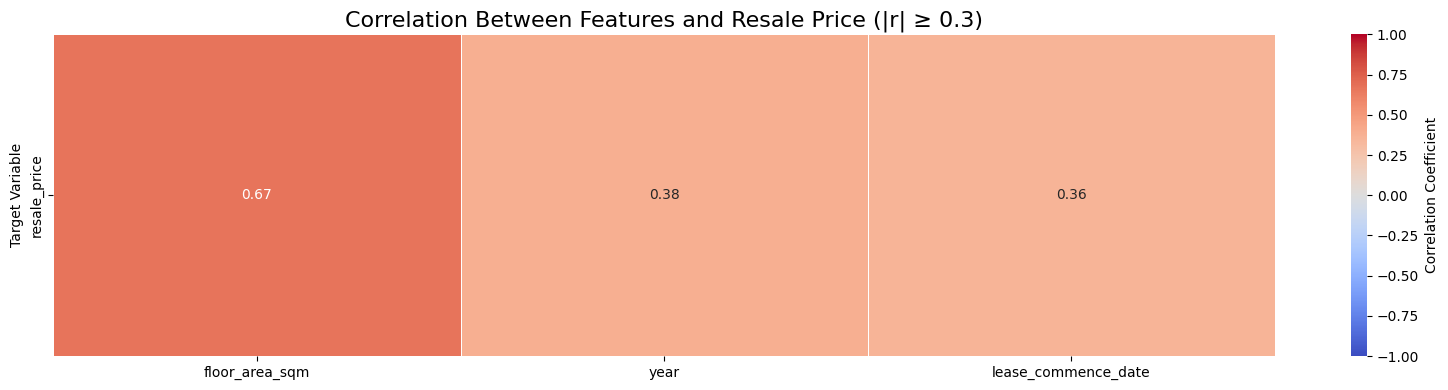

In [183]:
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlations with resale price
price_correlations = numerical_features.corr()['resale_price'].drop('resale_price')

# Define correlation threshold
threshold = 0.3  # You can adjust this value based on your needs

# Filter correlations based on threshold
significant_correlations = price_correlations[abs(price_correlations) >= threshold]

# Sort by absolute correlation value
sorted_correlations = significant_correlations.abs().sort_values(ascending=False)
sorted_features = sorted_correlations.index

# Create a DataFrame for the heatmap
heatmap_df = pd.DataFrame(price_correlations[sorted_features]).T

# Create the heatmap
plt.figure(figsize=(16, 4))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})

plt.title(f'Correlation Between Features and Resale Price (|r| ≥ {threshold})', fontsize=16)
plt.ylabel('Target Variable')
plt.tight_layout()
plt.show()

# 5) Feature Scaling

In [171]:
# List of numerical features
numerical_features = ['month', 'floor_area_sqm', 'lease_commence_date', 'resale_price',
                      'Latitude', 'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance',
                      'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count',
                      'mrt_count', 'mall_count', 'school_count', 'year', 'remaining_lease_months',
                      'storey_level']

# List of categorical features (one-hot encoded)
categorical_features = [col for col in df.columns if col not in numerical_features]

# storing values before one hot encoding for xgboost usage
original_numerical_stats = {}
for col in numerical_features:
    original_numerical_stats[col] = {"mean": df[col].mean(), "std": df[col].std()}

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Combine the scaled numerical features with the one-hot encoded categorical features
scaled_df = pd.concat([df[numerical_features], df[categorical_features]], axis=1)

# Display the first few rows of the scaled DataFrame
print(scaled_df.head())

      month  floor_area_sqm  lease_commence_date  resale_price  Latitude  \
0 -1.683811       -2.420165             1.762744     -1.946964 -0.663739   
1 -1.683811       -1.799849            -0.731921     -1.807999  0.742408   
2 -1.683811       -1.469013            -0.824316     -1.634293 -1.398236   
3 -1.683811       -1.427659            -0.731921     -1.599552  0.979585   
4 -1.683811       -1.634431            -0.547131     -1.564811  1.023701   

   Longitude  nearest_bus_stop_distance  nearest_mrt_distance  \
0   0.882588                  -0.684586              0.031269   
1  -0.099482                  -0.715115             -0.612541   
2  -0.848955                   0.204892              1.509028   
3   0.047813                   0.074553              1.122947   
4   1.010286                  -0.313639              0.776805   

   nearest_mall_distance  nearest_school_distance  ...  flat_model_DBSS  \
0              -0.494591                 0.303848  ...              0.0   
1 

# 6) Data Splitting & Feature Selection

Data Splitting

In [172]:
# Replace missing values in numerical features with their median values
for col in numerical_features:
    median_val = scaled_df[col].median()
    scaled_df[col] = scaled_df[col].fillna(median_val)

# Reverse scaling for all numerical features using stored means/stds
for col in numerical_features:
    scaled_df[col] = (scaled_df[col] * original_numerical_stats[col]["std"]) + original_numerical_stats[col]["mean"]

# Round and convert numerical values back to original form
scaled_df["month"] = scaled_df["month"].round().astype("Int64")
scaled_df["year"] = scaled_df["year"].round().astype("Int64")
scaled_df["storey_level"] = scaled_df["storey_level"].round().astype("Int64")
scaled_df["lease_commence_date"] = scaled_df["lease_commence_date"].round().astype("Int64")

# Sort dataset by year and month
scaled_df.sort_values(by=["year", "month"], ascending=[True, True], inplace=True)

# For each categorical variable, specify the prefix that the dummy columns share
categories = {
    "flat_type": "flat_type_",
    "flat_model": "flat_model_",
    "street_name": "street_name_",
}

# Convert one-hot encoded dummy columns back to a single categorical column
for col in categories:
    one_hot_cols = [c for c in scaled_df.columns if c.startswith(f"{col}_")]
    if one_hot_cols:
        scaled_df[col] = scaled_df[one_hot_cols].idxmax(axis=1).str[len(col) + 1:]
        scaled_df.drop(columns=one_hot_cols, inplace=True)

# Now define the training (≤2022) and testing (≥2023) sets
train_df = scaled_df[scaled_df['year'] <= 2022].copy()
test_df = scaled_df[scaled_df['year'] >= 2023].copy()

# Copy original data
rf_Xtrain_df = train_df.copy()
rf_ytrain_df = train_df.copy()
rf_Xtest_df = test_df.copy()
rf_ytest_df = test_df.copy()
# print("\nCopy original data\n", rf_Xtrain_df.head())

# Define features and target variable
rf_X_train = rf_Xtrain_df.drop(columns=["resale_price"])
rf_y_train = rf_ytrain_df["resale_price"]
rf_X_test = rf_Xtest_df.drop(columns=["resale_price"])
rf_y_test = rf_ytest_df["resale_price"]

print("\nX Test Columns", rf_X_test.columns)
print(f"\nTraining set size: {rf_X_train.shape[0]} rows, Testing set size: {rf_X_test.shape[0]} rows")



X Test Columns Index(['month', 'floor_area_sqm', 'lease_commence_date', 'Latitude',
       'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance',
       'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count',
       'mrt_count', 'mall_count', 'school_count', 'year',
       'remaining_lease_months', 'storey_level', 'flat_type', 'flat_model',
       'street_name'],
      dtype='object')

Training set size: 9276 rows, Testing set size: 3284 rows


Feature Selection Using Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OrdinalEncoder


print("\nX Train Columns\n", rf_X_train.columns)

# Specify the categorical columns that still contain string values
categorical_columns = ["flat_model", "street_name", "flat_type"]

# One-hot encode the categorical features for both training and testing sets
rf_X_train = pd.get_dummies(rf_X_train, columns=categorical_columns, drop_first=True)
rf_X_test = pd.get_dummies(rf_X_test, columns=categorical_columns, drop_first=True)

# For each categorical variable, specify the prefix that the dummy columns share
categories = {
    "flat_type": "flat_type_",
    "flat_model": "flat_model_",
    "street_name": "street_name_",
}

# Convert one-hot encoded dummy columns back to a single categorical column in the training set
for new_col, prefix in categories.items():
    one_hot_cols_train = [col for col in rf_X_train.columns if col.startswith(prefix)]
    if one_hot_cols_train:
        rf_X_train[new_col] = rf_X_train[one_hot_cols_train].idxmax(axis=1).str.replace(prefix, '', regex=False)
        rf_X_train.drop(columns=one_hot_cols_train, inplace=True)

# Do the same conversion for the test set
for new_col, prefix in categories.items():
    one_hot_cols_test = [col for col in rf_X_test.columns if col.startswith(prefix)]
    if one_hot_cols_test:
        rf_X_test[new_col] = rf_X_test[one_hot_cols_test].idxmax(axis=1).str.replace(prefix, '', regex=False)
        rf_X_test.drop(columns=one_hot_cols_test, inplace=True)

# Reindex the test set so it has the same columns as the training set
rf_X_test = rf_X_test.reindex(columns=rf_X_train.columns, fill_value=0)

cat_cols = list(categories.keys())
for col in cat_cols:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    # OrdinalEncoder expects a 2D array, so we use double brackets
    rf_X_train[col] = oe.fit_transform(rf_X_train[[col]]).astype(int)
    rf_X_test[col] = oe.transform(rf_X_test[[col]]).astype(int)

# Define base features (always included)
base_features = ["floor_area_sqm", "year", "lease_commence_date", "flat_model", "street_name"]

# Get remaining features by excluding base features
remaining_features = [col for col in rf_X_train.columns if col not in base_features]

print("\nRemaining Features\n", remaining_features)

# Initialize the model
model = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=5,
    min_samples_split=5
)

# Store results
best_n_features = None
best_rmse = float("inf")
best_selected_features = None

print("\n")

# Try different numbers of features
for n in range(1, len(remaining_features) + 1):
    rfe = RFE(estimator=model, n_features_to_select=n, step=1)
    rfe.fit(rf_X_train[remaining_features], rf_y_train)
    
    # Get selected features from remaining_features
    selected_rfe_features = rf_X_train[remaining_features].columns[rfe.support_]
    
    # Combine base features and selected features
    final_selected_features = list(base_features) + list(selected_rfe_features)
    
    # Train model with selected features
    model.fit(rf_X_train[final_selected_features], rf_y_train)
    rf_y_pred = model.predict(rf_X_test[final_selected_features])
    
    # Evaluate performance
    rmse = mean_squared_error(rf_y_test, rf_y_pred) ** 0.5
    print(f"n_features={n}, RMSE={rmse}")
    
    # Update best selection if RMSE improves
    if rmse < best_rmse:
        best_rmse = rmse
        best_n_features = n
        best_selected_features = final_selected_features

# Print best results
print("\nBest number of features:", best_n_features)
print("Best selected features:", best_selected_features)
print("Best RMSE:", best_rmse)

# Use the best selected features for final training
rf_X_train = rf_X_train[best_selected_features]
rf_X_test = rf_X_test[best_selected_features]


X Train Columns Index(['month', 'floor_area_sqm', 'lease_commence_date', 'Latitude',
       'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance',
       'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count',
       'mrt_count', 'mall_count', 'school_count', 'year',
       'remaining_lease_months', 'storey_level', 'flat_type', 'flat_model',
       'street_name'],
      dtype='object')
Remaining Features
 ['month', 'Latitude', 'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance', 'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count', 'mrt_count', 'mall_count', 'school_count', 'remaining_lease_months', 'storey_level', 'flat_type']
n_features=1, RMSE=79218.69380715313
n_features=2, RMSE=81754.43212270868
n_features=3, RMSE=81793.00435039165
n_features=4, RMSE=81821.9356951758
n_features=5, RMSE=81843.72810293324
n_features=6, RMSE=81866.63155200495
n_features=7, RMSE=81902.01160631774
n_features=8, RMSE=81902.14664225596
n_features=9, 

# 7) Random Forest Regressor Model

Model Training

In [174]:
# Use features found from RFE
numeric_features = [
    'floor_area_sqm', 'year', 'lease_commence_date', 'Longitude'
]

categorical_features = [
    'flat_model', 'street_name'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for BaggingRegressor
    bagging_n_estimators = trial.suggest_categorical('bagging_n_estimators', [10, 20, 30])
    bagging_max_samples = trial.suggest_float('bagging_max_samples', 0.5, 1.0)
    bagging_max_features = trial.suggest_float('bagging_max_features', 0.5, 1.0)
    
    # Suggest hyperparameters for the RandomForestRegressor (base estimator)
    rf_n_estimators = trial.suggest_categorical('rf_n_estimators', [50, 100, 200])
    rf_max_depth = trial.suggest_categorical('rf_max_depth', [None, 10, 20])
    rf_min_samples_split = trial.suggest_categorical('rf_min_samples_split', [2, 5, 10])
    
    # Build the base RandomForestRegressor with suggested hyperparameters
    base_model = RandomForestRegressor(
        random_state=42,
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split
    )
    
    # Build the BaggingRegressor with the suggested hyperparameters
    bagging_model = BaggingRegressor(
        estimator=base_model,
        random_state=42,
        n_jobs=-1,
        n_estimators=bagging_n_estimators,
        max_samples=bagging_max_samples,
        max_features=bagging_max_features
    )
    
    # Create the pipeline
    """
    pipeline ensures that data is consistently preprocessed and
    passed to ensemble model (BaggingRegressor), which further boosts 
    performance by combining multiple instances of optimized RandomForestRegressor. 
    This integration simplifies the code and reduces the risk of mismatched
    transformations between training and testing.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', bagging_model)
    ])
    
    # Use cross-validation to estimate RMSE (using negative MSE, then taking sqrt)
    scores = cross_val_score(
        pipeline, rf_X_train, rf_y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse = np.sqrt(-np.mean(scores))
    
    return rmse

# Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Print the best hyperparameters and the corresponding RMSE
print("Best hyperparameters found:")
print(study.best_trial.params)
print(f"Best RMSE: {study.best_trial.value:.4f}")


[I 2025-03-06 13:55:27,819] A new study created in memory with name: no-name-602d6b3a-1473-4d45-9803-92aecf4a2953
[I 2025-03-06 13:56:13,200] Trial 0 finished with value: 48147.28699894025 and parameters: {'bagging_n_estimators': 10, 'bagging_max_samples': 0.7461923517140528, 'bagging_max_features': 0.9339202730644256, 'rf_n_estimators': 200, 'rf_max_depth': None, 'rf_min_samples_split': 10}. Best is trial 0 with value: 48147.28699894025.
[I 2025-03-06 13:56:46,163] Trial 1 finished with value: 65865.65579689477 and parameters: {'bagging_n_estimators': 20, 'bagging_max_samples': 0.9008494055492154, 'bagging_max_features': 0.5003978572410266, 'rf_n_estimators': 100, 'rf_max_depth': None, 'rf_min_samples_split': 5}. Best is trial 0 with value: 48147.28699894025.
[I 2025-03-06 13:56:52,309] Trial 2 finished with value: 56846.07416558116 and parameters: {'bagging_n_estimators': 10, 'bagging_max_samples': 0.8033319005227172, 'bagging_max_features': 0.553083505342622, 'rf_n_estimators': 50, 

Best hyperparameters found:
{'bagging_n_estimators': 20, 'bagging_max_samples': 0.708872947134366, 'bagging_max_features': 0.9583774523306836, 'rf_n_estimators': 200, 'rf_max_depth': 20, 'rf_min_samples_split': 2}
Best RMSE: 47541.1329


In [175]:
# Extract best parameters
bp = study.best_trial.params
print("Use the following hyperparameters to train model:")
print(bp)

# Create and train the final pipeline in one go
best_hyperparameters_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(
        estimator=RandomForestRegressor(
            random_state=42,
            n_estimators=bp['rf_n_estimators'],
            max_depth=bp['rf_max_depth'],
            min_samples_split=bp['rf_min_samples_split']
        ),
        random_state=42,
        n_jobs=-1,
        n_estimators=bp['bagging_n_estimators'],
        max_samples=bp['bagging_max_samples'],
        max_features=bp['bagging_max_features']
    ))
])

best_hyperparameters_pipeline.fit(rf_X_train, rf_y_train)

# Notify when model training is completed
print("\nCompleted training Random Forest Regressor Model with best hyperparameters found")

Use the following hyperparameters to train model:
{'bagging_n_estimators': 20, 'bagging_max_samples': 0.708872947134366, 'bagging_max_features': 0.9583774523306836, 'rf_n_estimators': 200, 'rf_max_depth': 20, 'rf_min_samples_split': 2}

Completed training Random Forest Regressor Model with best hyperparameters found


Model Performance Metrics
- Trained model using best correlation features for resale price + identified features from RFE

In [176]:
# Function to calculate accuracy of predicted resale prices
def calculate_accuracy(y_actual, y_predicted):
    y_actual, y_predicted = np.array(y_actual), np.array(y_predicted)

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100

    # Convert MAPE to Accuracy
    accuracy = 100 - mape
    return accuracy


# Evaluate the model
y_pred = best_hyperparameters_pipeline.predict(rf_X_test)
accuracy = calculate_accuracy(rf_y_test, y_pred)
mae = mean_absolute_error(rf_y_test, y_pred)

# Show results
print("Trained Random Forest Regressor Model Performance")
print(f"R²: {r2_score(rf_y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(rf_y_test, y_pred)):.4f}")
print(f"MAE: {mae:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

Trained Random Forest Regressor Model Performance
R²: 0.6458
RMSE: 81443.6952
MAE: 67844.35
Accuracy: 89.28%


Model Performance Visuals

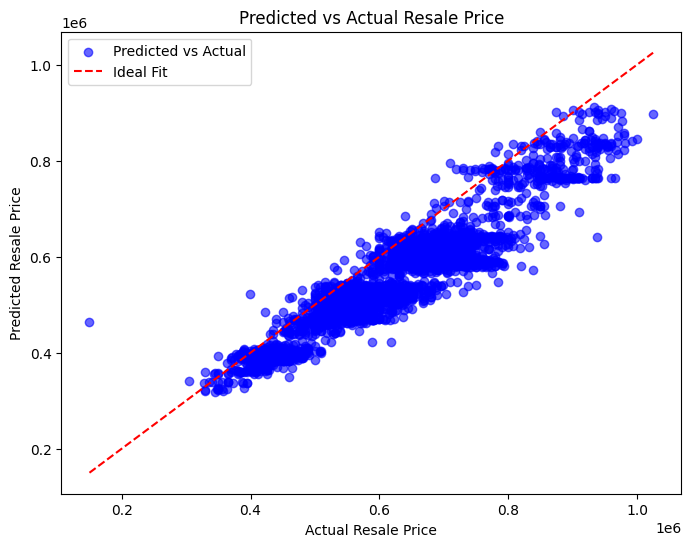

In [177]:
# Scatter Plot
"""
Scatter plot helps visually assess how well the model's predictions match the actual resale prices, 
with the ideal line showing where predictions would be perfect.
"""

plt.figure(figsize=(8, 6))
plt.scatter(rf_y_test, y_pred, alpha=0.6, color='b', label='Predicted vs Actual')
plt.plot([min(rf_y_test), max(rf_y_test)], [min(rf_y_test), max(rf_y_test)], 'r--', label='Ideal Fit')
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.legend()
plt.show()

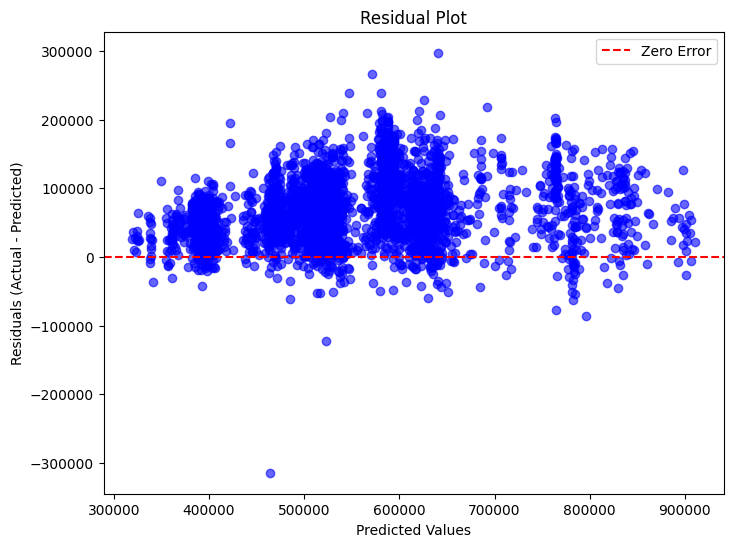

In [178]:
# Residual Plot
"""
Residual Plot shows the residuals (errors) versus the predicted values. It helps to see if the 
errors are randomly distributed (which is ideal) or if there's a pattern (indicating potential issues).
"""

# Calculate residuals
residuals = rf_y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.legend()
plt.show()

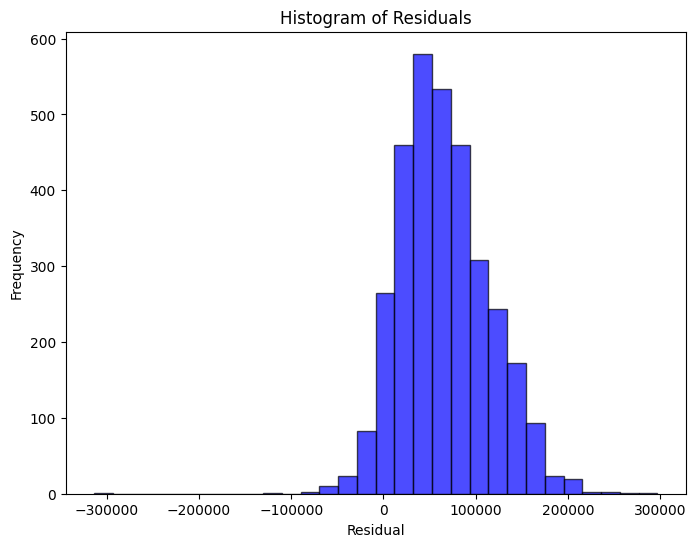

In [179]:
# Histogram of Residuals
"""
A histogram of residuals shows their distribution. Ideally, the residuals should be approximately normally 
distributed around zero, suggesting that the model’s errors are random.
"""

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

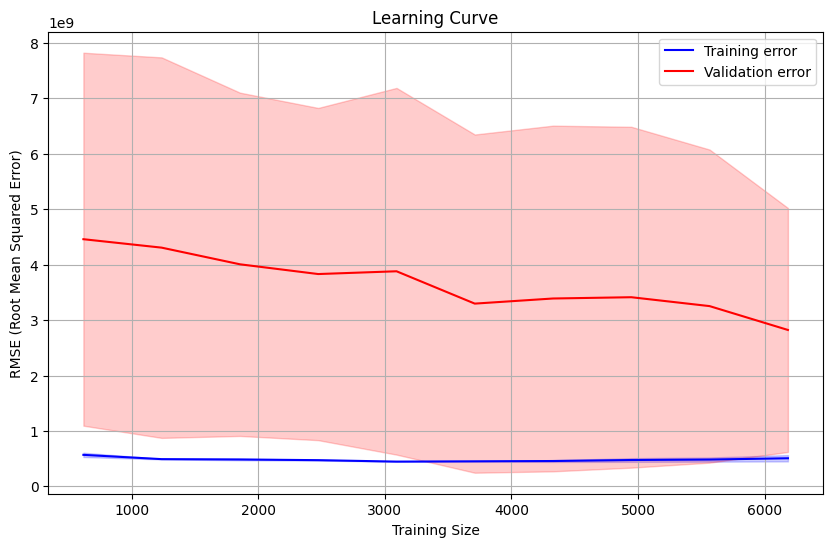

In [184]:
# Learning Curve
"""
Learning curve graph visualizes the model performance as the training set size increases by plotting 
Root Mean Squared Error (RMSE) against Training Size.
"""

# Define the estimator (in this case, the final pipeline with the best hyperparameters)
best_hyperparameters_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(
        estimator=RandomForestRegressor(
            random_state=42,
            n_estimators=bp['rf_n_estimators'],
            max_depth=bp['rf_max_depth'],
            min_samples_split=bp['rf_min_samples_split']
        ),
        random_state=42,
        n_jobs=-1,
        n_estimators=bp['bagging_n_estimators'],
        max_samples=bp['bagging_max_samples'],
        max_features=bp['bagging_max_features']
    ))
])

# Generate the learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    best_hyperparameters_pipeline,  # The pipeline with the model and preprocessor
    rf_X_train,  # Training features
    rf_y_train,  # Training target variable
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Scoring metric (negative MSE for regression)
    n_jobs=-1,  # Use all available cores for parallel processing
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the training data
)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = -np.mean(train_scores, axis=1)  # Convert negative MSE to RMSE (Root Mean Squared Error)
train_std = np.std(train_scores, axis=1)  # Standard deviation of training error
validation_mean = -np.mean(validation_scores, axis=1)  # Convert negative MSE to RMSE for validation error
validation_std = np.std(validation_scores, axis=1)  # Standard deviation of validation error

# Plot the learning curve
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.plot(train_sizes, train_mean, label="Training error", color="blue")  # Plot training error
plt.plot(train_sizes, validation_mean, label="Validation error", color="red")  # Plot validation error

# Fill between the lines for training and validation error to show the variability (standard deviation)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)  # Shaded area for training error
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="red", alpha=0.2)  # Shaded area for validation error

# Set plot title and axis labels
plt.title("Learning Curve")  # Title of the plot
plt.xlabel("Training Size")  # Label for the x-axis (Training set size)
plt.ylabel("RMSE (Root Mean Squared Error)")  # Label for the y-axis (Model error)

# Add legend and grid for better readability
plt.legend()  # Show legend to distinguish between training and validation error
plt.grid(True)  # Show gridlines on the plot for better clarity

# Display the plot
plt.show()

- Training error (blue) is consistently low.
- Validation error (red) starts higher but decreases as training size grows.
- The wide red band indicates high variance in validation performance.
- The persistent gap between training and validation error suggests overfitting (model performs much better on the training data than the validation data).
- Adding more data gradually narrows this gap and improves validation performance.